In [1]:
# from ultralytics import YOLO
import cv2
from IPython.display import display
from IPython.display import Image as  Image_DIS
from PIL import Image as Image_PIL
from util import postprocess, preprocess_image, image_to_tensor, draw_results
import numpy as np
import torch
from notebook_utils import  VideoPlayer
from tqdm import tqdm

from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class
from ultralytics.data.utils import check_det_dataset
from ultralytics.engine.validator import BaseValidator as Validator
from ultralytics.models.yolo import YOLO
from ultralytics.utils import DATASETS_DIR
from ultralytics.utils import DEFAULT_CFG
from ultralytics.utils import ops
from ultralytics.utils.metrics import ConfusionMatrix


import re
import subprocess
from functools import partial
from pathlib import Path
from typing import Any, Dict, Tuple


# Utils

In [ ]:
# torch_model.export(format="openvino", dynamic=True, half = False)

In [2]:
import ipywidgets as widgets
import openvino as ov

#tạo openvino runtime
core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [10]:
# Khởi tạo model
torch_model = YOLO("./model/car_detection.pt")
lp_detection = YOLO(r"C:\Users\TranNgocDu\Documents\LPRecognition\LP_recognition\model\best_lp_detection_yolov8n.pt")
lpov_model, lpov_model_complied = read_model_ov(r"C:\Users\TranNgocDu\Documents\LPRecognition\LP_recognition\model\best_lp_detection_yolov8n_openvino_model\best_lp_detection_yolov8n.xml")
detcar_ov_model, detcar_compiled_model = read_model_ov(r"C:\Users\TranNgocDu\Documents\LPRecognition\LP_recognition\model\car_detection_openvino_model\car_detection.xml")



image 1/1 C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\images\val\xemay870.jpg: 416x640 1 lp, 379.1ms
Speed: 0.7ms preprocess, 379.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


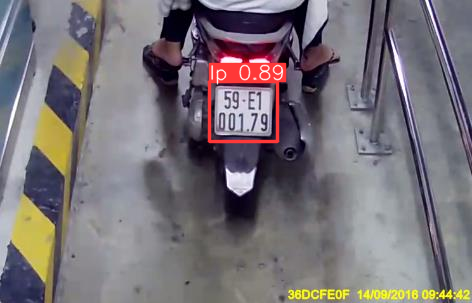

In [11]:
show_detect_torch(lp_detection, r"C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\images\val\xemay870.jpg")

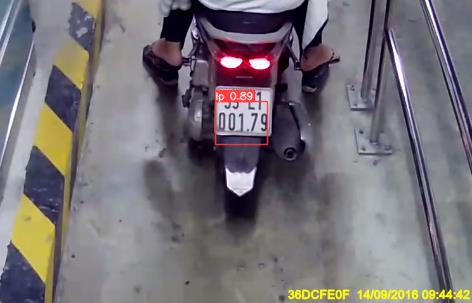

In [12]:
show_detect_openvino(lpov_model_complied,\
                     r"C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\images\val\xemay870.jpg",\
                        lp_detection.names, nc=1)

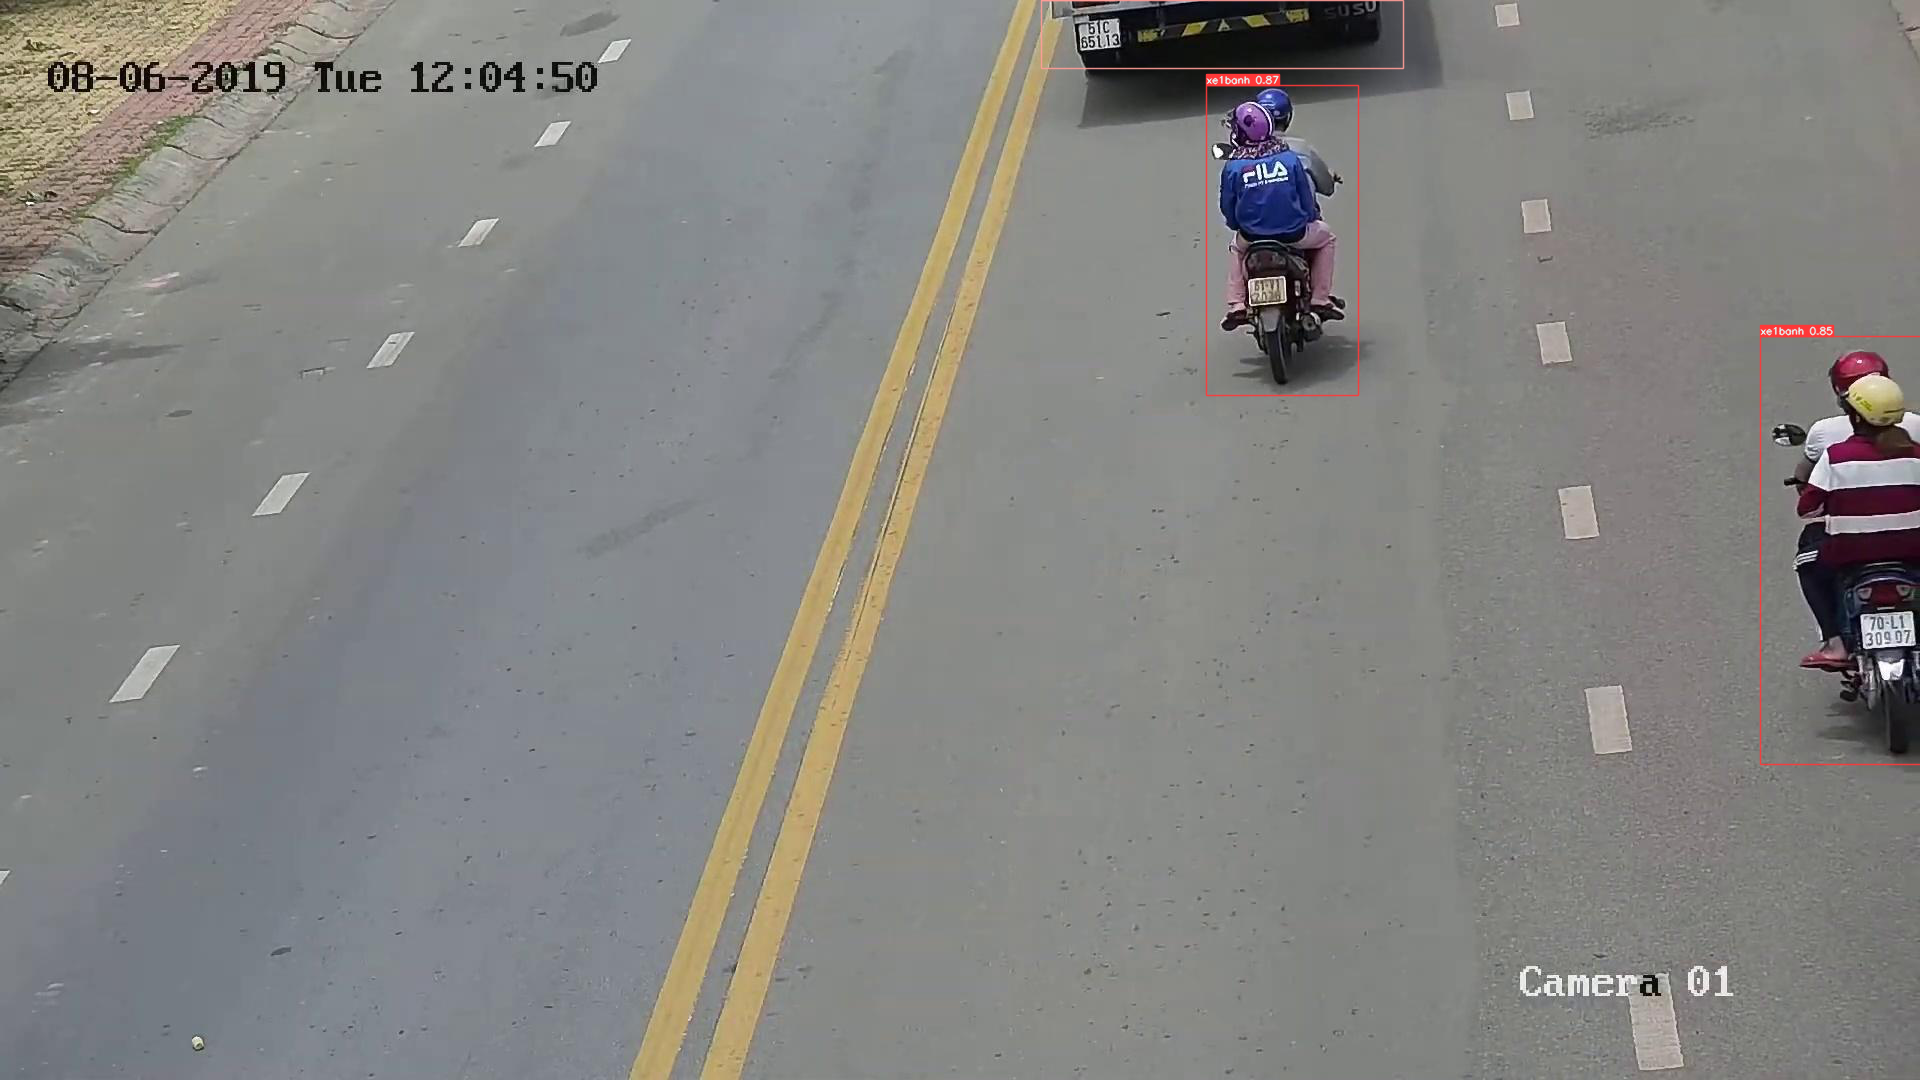

In [13]:
show_detect_openvino(detcar_compiled_model,\
                      r"C:\Users\TranNgocDu\Documents\LPRecognition\datasets\Vehicle_detection\valid\images\frame7280_jpg.rf.fc40abcf29a608afcec338355552f737.jpg",
                      torch_model.names)

# Inference

## Inference model yolo


image 1/1 C:\Users\TranNgocDu\Documents\LPRecognition\datasets\Vehicle_detection\valid\images\frame7280_jpg.rf.fc40abcf29a608afcec338355552f737.jpg: 384x640 2 xe1banhs, 1 xe2banh, 581.1ms
Speed: 6.8ms preprocess, 581.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


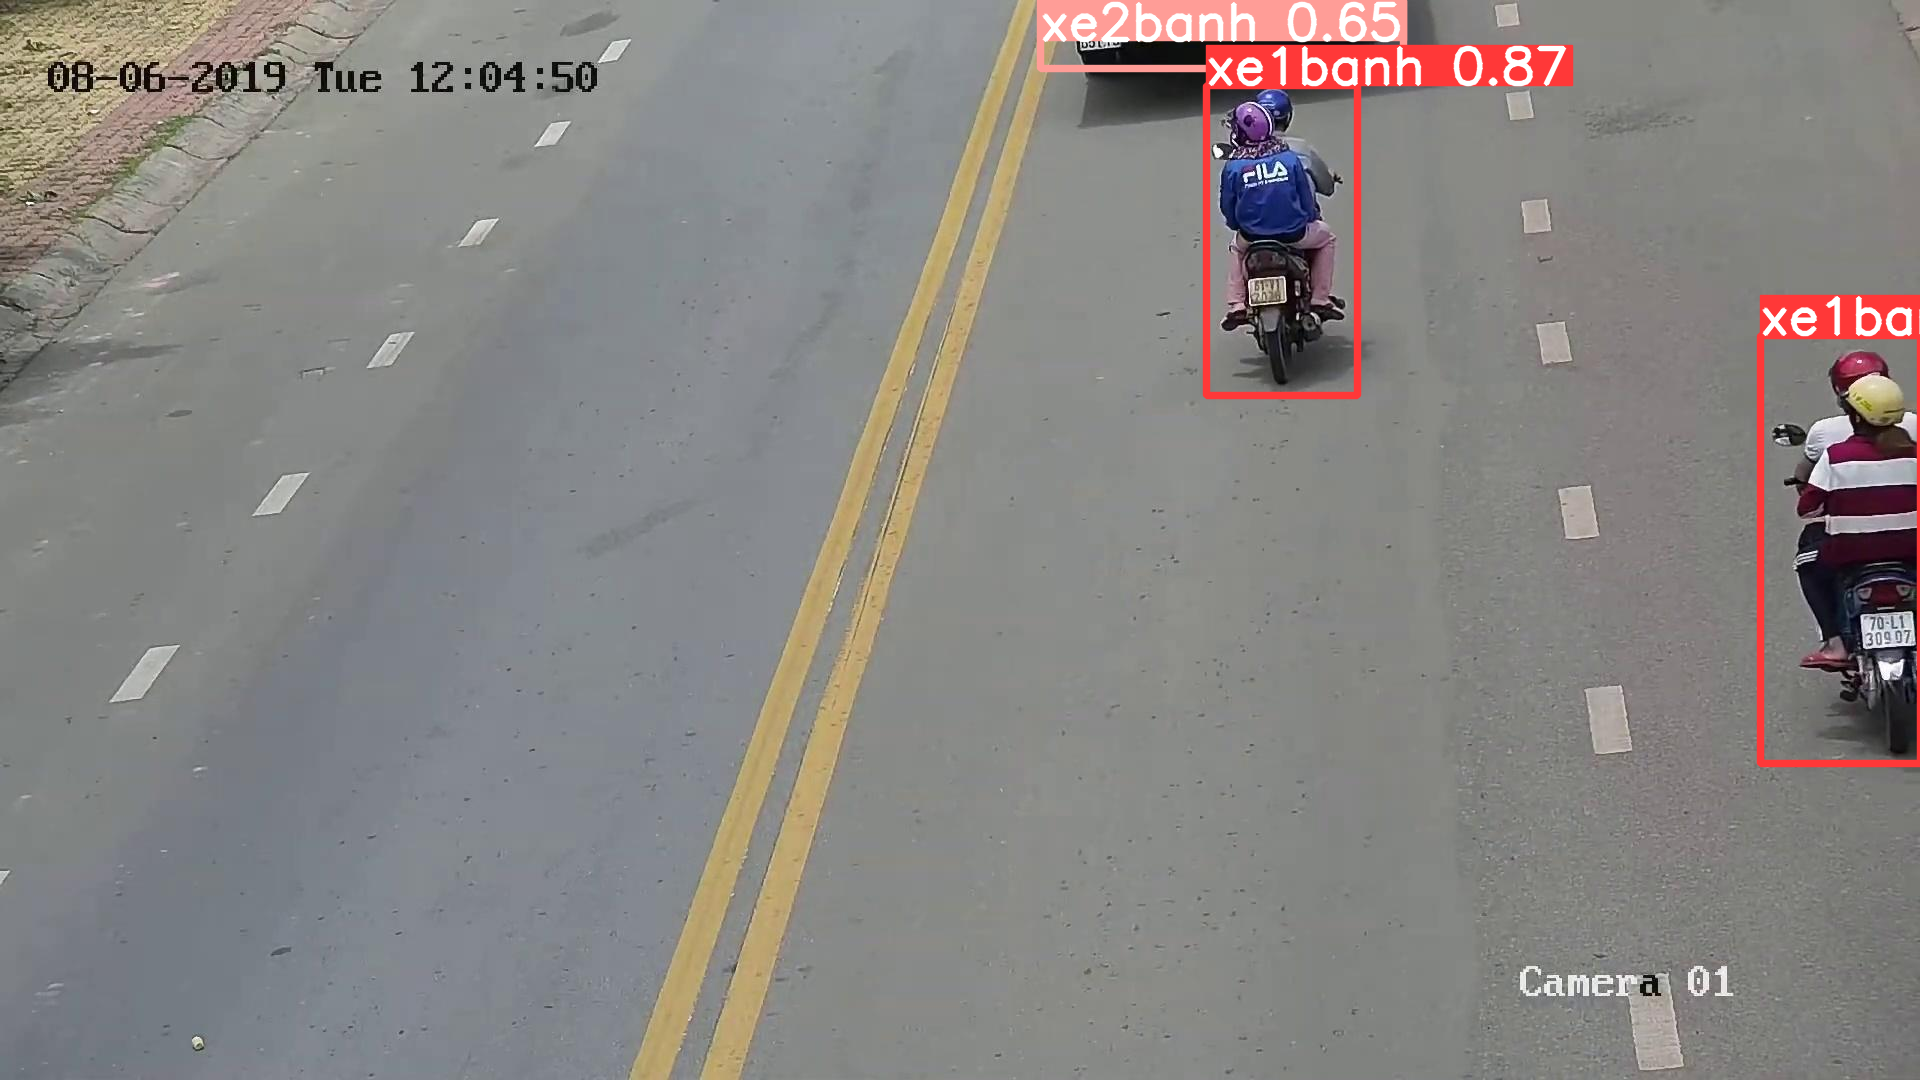

In [10]:

show_detect_torch(torch_model, r"C:\Users\TranNgocDu\Documents\LPRecognition\datasets\Vehicle_detection\valid\images\frame7280_jpg.rf.fc40abcf29a608afcec338355552f737.jpg")

## Inference model openvino

# Validation

## Valuation model Yolo

In [12]:
# test model yolov8 pytorch
validation_results = torch_model.val(data=r'C:\Users\TranNgocDu\Documents\LPRecognition\datasets\Vehicle_detection/data.yaml',
                               imgsz=640,
                               batch=16,
                               conf=0.25,
                               iou=0.5)

Ultralytics YOLOv8.0.170  Python-3.9.18 torch-2.1.2 CPU (Intel Core(TM) i5-6200U 2.30GHz)
val: Scanning C:\Users\TranNgocDu\Documents\LPRecognition\datasets\Vehicle_detection\valid\labels... 162 images, 74 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:00<00:00, 314.58it/s]
val: New cache created: C:\Users\TranNgocDu\Documents\LPRecognition\datasets\Vehicle_detection\valid\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:18<00:00,  7.16s/it]
                   all        162        105      0.937      0.961      0.973      0.761
               xe1banh        162         44      0.921      0.955      0.971      0.704
               xe2banh        162         61      0.952      0.967      0.976      0.818
Speed: 3.2ms preprocess, 442.7ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\val5


In [22]:
# test model yolov8 pytorch
validation_results = lp_detection.val(data=r'C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\data.yaml',
                               imgsz=640,
                               batch=16,
                               conf=0.25,
                               iou=0.5)

Ultralytics YOLOv8.0.170  Python-3.9.18 torch-2.1.2 CPU (Intel Core(TM) i5-6200U 2.30GHz)
val: Scanning C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\labels\val... 1652 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1652/1652 [00:01<00:00, 852.24it/s]
val: New cache created: C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\labels\val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [07:49<00:00,  4.52s/it]
                   all       1652       1667      0.996      0.995      0.995      0.764
Speed: 3.5ms preprocess, 266.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\val6


## Make Validator Yolo Openvino

# Quantization

In [18]:
import nncf  # noqa: F811
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


In [19]:
ignored_scope = nncf.IgnoredScope(
    types=["Multiply", "Subtract", "Sigmoid"],  # ignore operations
    names=[
        "/model.22/dfl/conv/Conv",           # in the post-processing subgraph
        "/model.22/Add",
        "/model.22/Add_1",
        "/model.22/Add_2",
        "/model.22/Add_3",
        "/model.22/Add_4",   
        "/model.22/Add_5",
        "/model.22/Add_6",
        "/model.22/Add_7",
        "/model.22/Add_8",
        "/model.22/Add_9",
        "/model.22/Add_10"
    ]
)


# Detection model
quantized_det_model = nncf.quantize(
    lpov_model,
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=ignored_scope
)

INFO:nncf:12 ignored nodes were found by name in the NNCFGraph
INFO:nncf:9 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 124 /model.22/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 151 /model.22/dfl/conv/Conv
INFO:nncf:Not adding activation input quantizer for operation: 173 /model.22/Sub
INFO:nncf:Not adding activation input quantizer for operation: 174 /model.22/Add_10
INFO:nncf:Not adding activation input quantizer for operation: 189 /model.22/Sub_1
INFO:nncf:Not adding activation input quantizer for operation: 213 /model.22/Mul_5


Output()

c:\Users\TranNgocDu\miniconda3\envs\yolov7\lib\site-packages\nncf\experimental\tensor\tensor.py:84: RuntimeWarning: invalid value encountered in multiply
  return Tensor(self.data * unwrap_tensor_data(other))


Output()

In [20]:
from openvino.runtime import serialize
DET_MODEL_NAME = "lp_detection"
int8_model_det_path = f"./model" + f'{DET_MODEL_NAME}_openvino_int8_model/{DET_MODEL_NAME}.xml'
print(f"Quantized detection model will be saved to {int8_model_det_path}")
serialize(quantized_det_model, str(int8_model_det_path))

Quantized detection model will be saved to ./modellp_detection_openvino_int8_model/lp_detection.xml


In [21]:
fp_det_stats = test(quantized_det_model, core, data_loader, validator)
print_stats(fp_det_stats, validator.seen, validator.nt_per_class.sum())

100%|██████████| 1652/1652 [04:03<00:00,  6.80it/s]

Boxes:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        1652        1667       0.988       0.992       0.995        0.74


In [23]:
!benchmark_app -m $int8_model_det_path -d "CPU" -api async -shape "[2,3,640,640]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.3.0-13775-ceeafaf64f3-releases/2023/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.3.0-13775-ceeafaf64f3-releases/2023/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 132.89 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,5,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 2
[ INFO ] Reshaping mo

In [26]:
compiled_model = core.compile_model(quantized_det_model, "CPU")


In [27]:
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[images] shape[1,3,?,?] type: f32>
]
outputs[
<ConstOutput: names[output0] shape[1,5,21..] type: f32>
]>

In [33]:
lpov_model_complied

<CompiledModel:
inputs[
<ConstOutput: names[images] shape[?,3,?,?] type: f32>
]
outputs[
<ConstOutput: names[output0] shape[?,5,21..] type: f32>
]>

In [32]:
inpt = np.random.rand(2,3,640,640)
lpov_model_complied(inpt)

{<ConstOutput: names[output0] shape[?,5,21..] type: f32>: array([[[     6.9025,      10.153,      22.796, ...,      535.87,      551.79,      643.15],
        [     5.1275,      4.7038,      4.6685, ...,      626.29,      648.68,      660.55],
        [     14.326,      21.523,       29.95, ...,      327.13,      276.18,      172.46],
        [     8.8401,      8.2661,      8.4845, ...,      261.86,      233.73,      214.69],
        [ 8.0262e-07,  1.0949e-06,    8.79e-09, ...,  2.0083e-07,  1.4898e-07,  2.2517e-07]],

       [[     16.888,      23.645,       25.61, ...,      535.77,      551.85,      643.22],
        [     7.3784,      5.7907,      5.9056, ...,      627.49,      649.56,      660.84],
        [      33.98,      47.477,      52.196, ...,      324.95,      273.94,      171.04],
        [     13.047,      10.618,      11.246, ...,      258.85,      231.53,      213.81],
        [ 6.2728e-09,   3.846e-09,   3.306e-11, ...,  2.0433e-07,  1.4736e-07,  2.1929e-07]]], dtype=fl

In [53]:
VIDEO_SOURCE = r"C:\Users\TranNgocDu\Documents\LPRecognition\video1.mp4"

In [29]:

import collections
import time
from IPython import display


# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model=det_ov_model, device=device.value):
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect(input_image[:, :, ::-1], compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes = draw_results(detections, input_image, label_map)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

def run_object_detection_pytorch(source=0, flip=False, use_popup=False, skip_first_frames=0, model=det_ov_model, device='cpu'):
    player = None
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = model.predict(input_image[:, :, ::-1], verbose=False, device=device)
            stop_time = time.time()
            
    
            frame = detections[0].plot()[:, :, ::-1].copy()
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            
            # print(frame.shape, type(frame), frame.dtype)
            
            cv2.putText(
                img=frame ,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

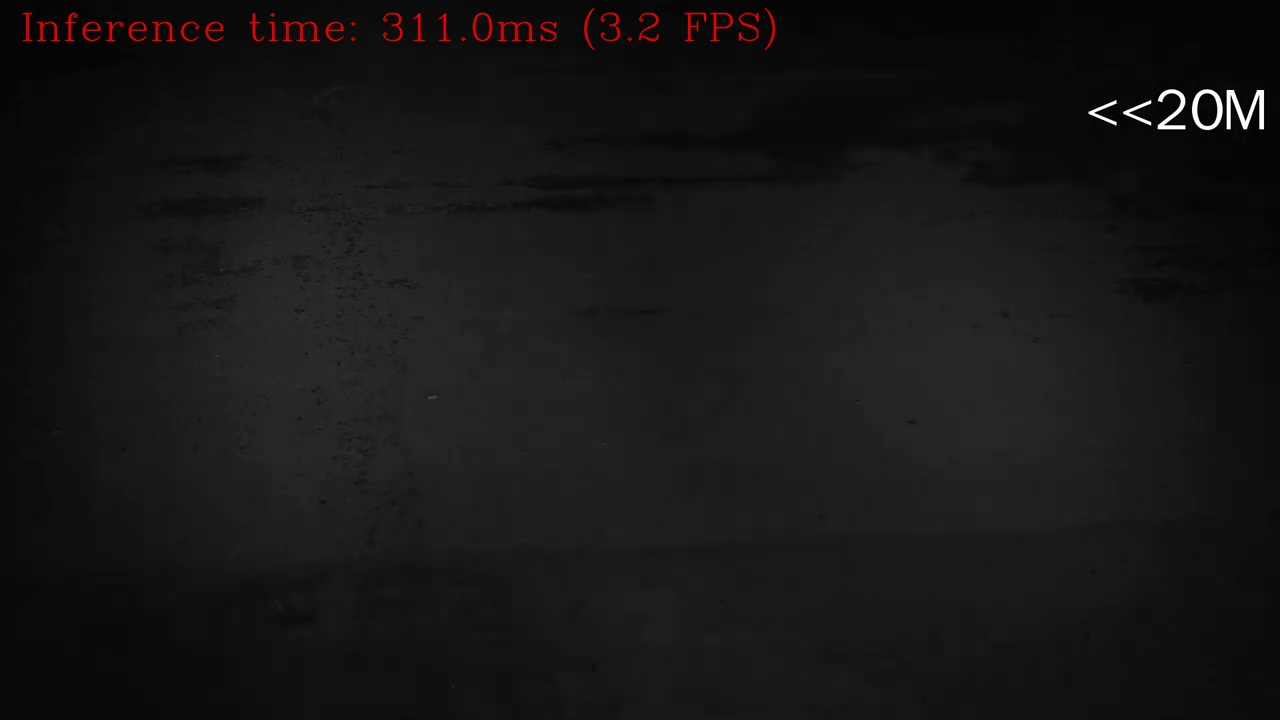

Interrupted


In [56]:
run_object_detection(source=VIDEO_SOURCE, flip=False, use_popup=False, model=quantized_det_model, device=device.value)